In [1]:
import pandas as pd
import numpy as np
df_class = pd.read_csv('data/classification_std.csv')
df_class.set_index('Model', inplace=True)
for dataset in ['BACE', 'BBBP', 'Tox21', 'ToxCast', 'SIDER', 'ClinTox']:
    df_class[f'{dataset}_train'] = np.array(0)
df_class.columns

Index(['BACE', 'BBBP', 'Tox21', 'ToxCast', 'SIDER', 'ClinTox', 'Avg',
       'BACEstd', 'BBBPstd', 'Tox21std', 'ToxCaststd', 'SIDERstd',
       'ClinToxstd', 'std', 'BACE_train', 'BBBP_train', 'Tox21_train',
       'ToxCast_train', 'SIDER_train', 'ClinTox_train'],
      dtype='object')

In [2]:
import numpy as np
np.random.seed(42)
results  = []
for model in df_class.index:
    model_train = []
    for dataset in ['BACE', 'BBBP', 'Tox21', 'ToxCast', 'SIDER', 'ClinTox']:
        model_train.append(np.random.normal(df_class.at[model, dataset], df_class.at[model, f"{dataset}std"], 3))
    results.append(model_train)

In [3]:
import scipy.stats as stats
train_kgg = np.array(results[-1]).mean(axis=0)
df_ttest = dict()
df_std = dict()
for idx, model in enumerate(df_class.index):
    train_other = np.array(results[idx]).mean(axis=0)
    df_ttest[model] = train_other
    df_std[f"{model}_std"] = np.array(results[idx]).std(axis=0)
    t_stat, p_value = stats.ttest_ind(train_other, train_kgg)
    # Kiểm tra kết quả
    alpha = 0.01  # Mức ý nghĩa
    if p_value < alpha:
        print(f"Model KGG tốt hơn có ý nghĩa thống kê model {model} với mức ý nghĩa {alpha}")
    else:
        print(f"Model KGG không tốt hơn có ý nghĩa thống kê so với model {model} với mức ý nghĩa {alpha}")

Model KGG tốt hơn có ý nghĩa thống kê model GraphSAGE với mức ý nghĩa 0.01
Model KGG tốt hơn có ý nghĩa thống kê model GPT GNN với mức ý nghĩa 0.01
Model KGG tốt hơn có ý nghĩa thống kê model MoCL với mức ý nghĩa 0.01
Model KGG tốt hơn có ý nghĩa thống kê model ContextPred với mức ý nghĩa 0.01
Model KGG tốt hơn có ý nghĩa thống kê model InfoGraph với mức ý nghĩa 0.01
Model KGG tốt hơn có ý nghĩa thống kê model GraphLoG với mức ý nghĩa 0.01
Model KGG tốt hơn có ý nghĩa thống kê model AttributeMask với mức ý nghĩa 0.01
Model KGG tốt hơn có ý nghĩa thống kê model MolCLR với mức ý nghĩa 0.01
Model KGG tốt hơn có ý nghĩa thống kê model G Motif với mức ý nghĩa 0.01
Model KGG không tốt hơn có ý nghĩa thống kê so với model GraphCL với mức ý nghĩa 0.01
Model KGG tốt hơn có ý nghĩa thống kê model JOAO với mức ý nghĩa 0.01
Model KGG tốt hơn có ý nghĩa thống kê model MGSSL với mức ý nghĩa 0.01
Model KGG tốt hơn có ý nghĩa thống kê model HiMol với mức ý nghĩa 0.01
Model KGG không tốt hơn có ý nghĩa

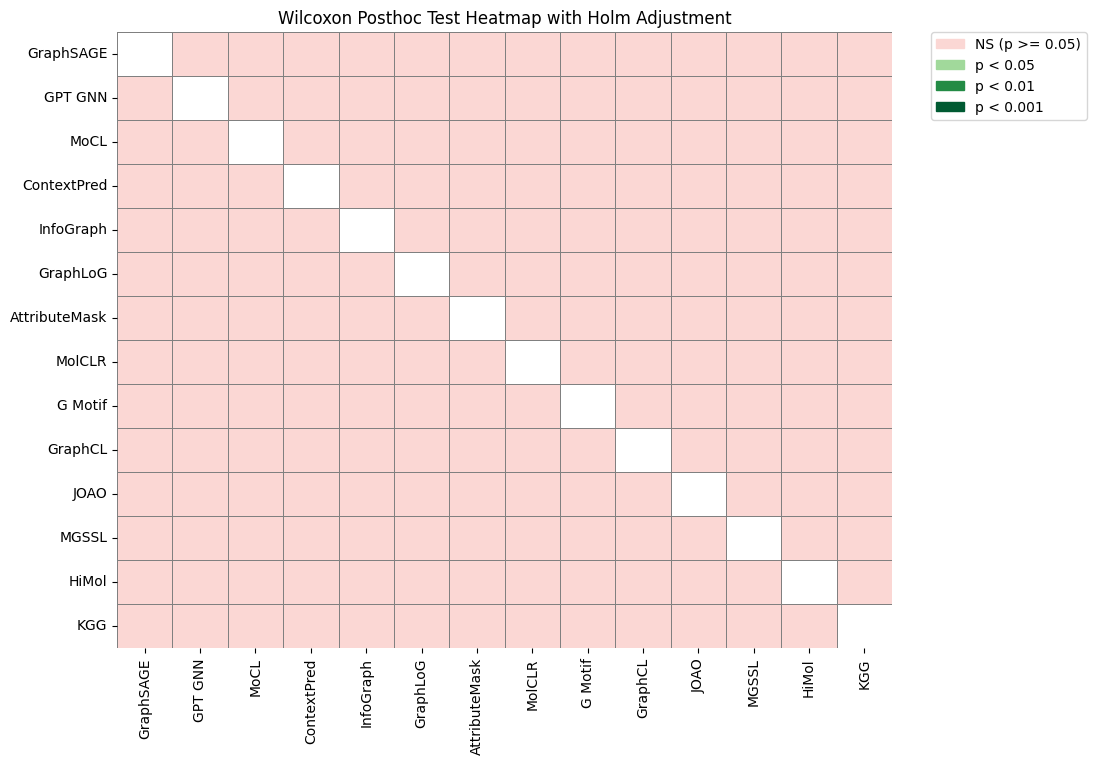

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikit_posthocs as sp

# Assuming df_ttest is your DataFrame
# df_ttest = pd.DataFrame(...)  # Your data goes here
df = pd.DataFrame(df_ttest)

# Melt the DataFrame to long format
df_melt = df.melt(var_name='Method', value_name='Scores')

# Perform pairwise Wilcoxon tests with Holm adjustment
p_values_df = sp.posthoc_wilcoxon(df_melt, val_col='Scores', group_col='Method', p_adjust='holm')

# Set diagonal values to NaN to avoid self-comparison
np.fill_diagonal(p_values_df.values, np.nan)

# Custom colormap for specific p-value ranges
def custom_heatmap(p_values):
    color_map = p_values.copy()
    color_map[p_values < 0.001] = 3
    color_map[(p_values >= 0.001) & (p_values < 0.01)] = 2
    color_map[(p_values >= 0.01) & (p_values < 0.05)] = 1
    color_map[p_values >= 0.05] = 0
    return color_map

color_map = custom_heatmap(p_values_df)

# Create a colormap with 4 colors
cmap = ['#fbd7d4', '#a1d99b', '#238b45', '#005a32']

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(color_map, annot=False, cmap=cmap, cbar=False, xticklabels=p_values_df.columns, yticklabels=p_values_df.index, linewidths=.5, linecolor='gray')
plt.title("Wilcoxon Posthoc Test Heatmap with Holm Adjustment")

# Add a legend
legend_labels = ['NS (p >= 0.05)', 'p < 0.05', 'p < 0.01', 'p < 0.001']
colors = ['#fbd7d4', '#a1d99b', '#238b45', '#005a32']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(colors))]

plt.legend(handles, legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig('fig/wilcoxon_heatmap_holm.png', dpi=600, transparent=False, bbox_inches='tight')
plt.show()



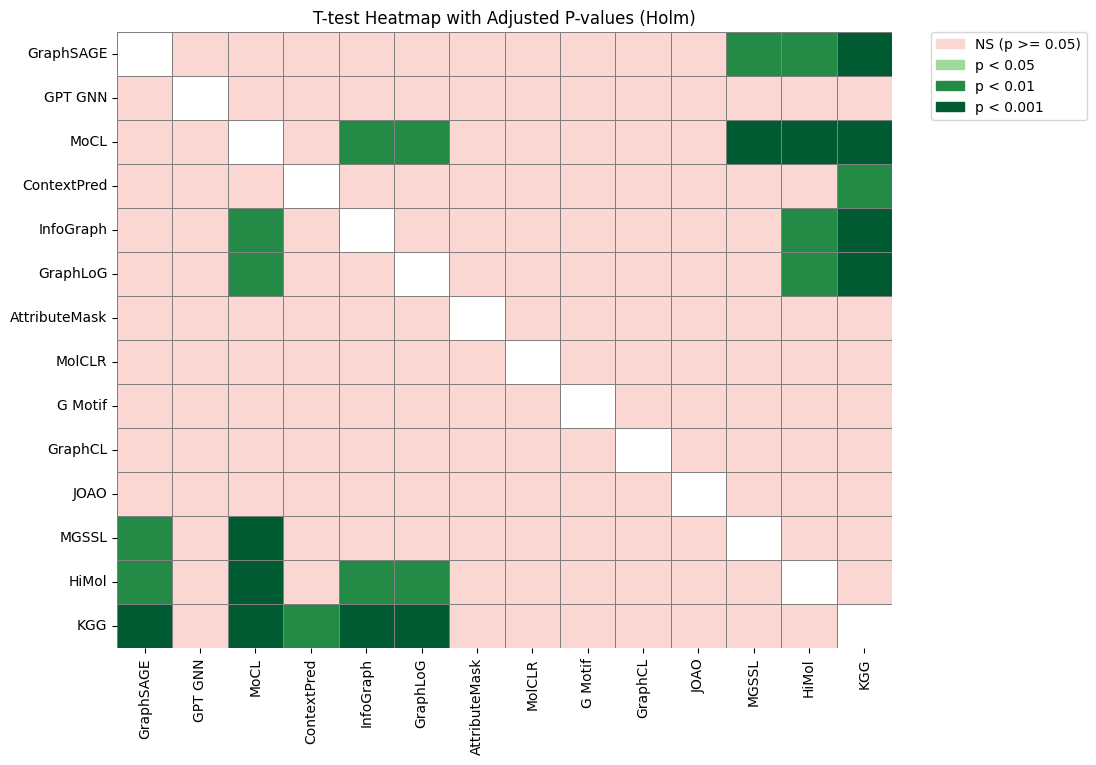

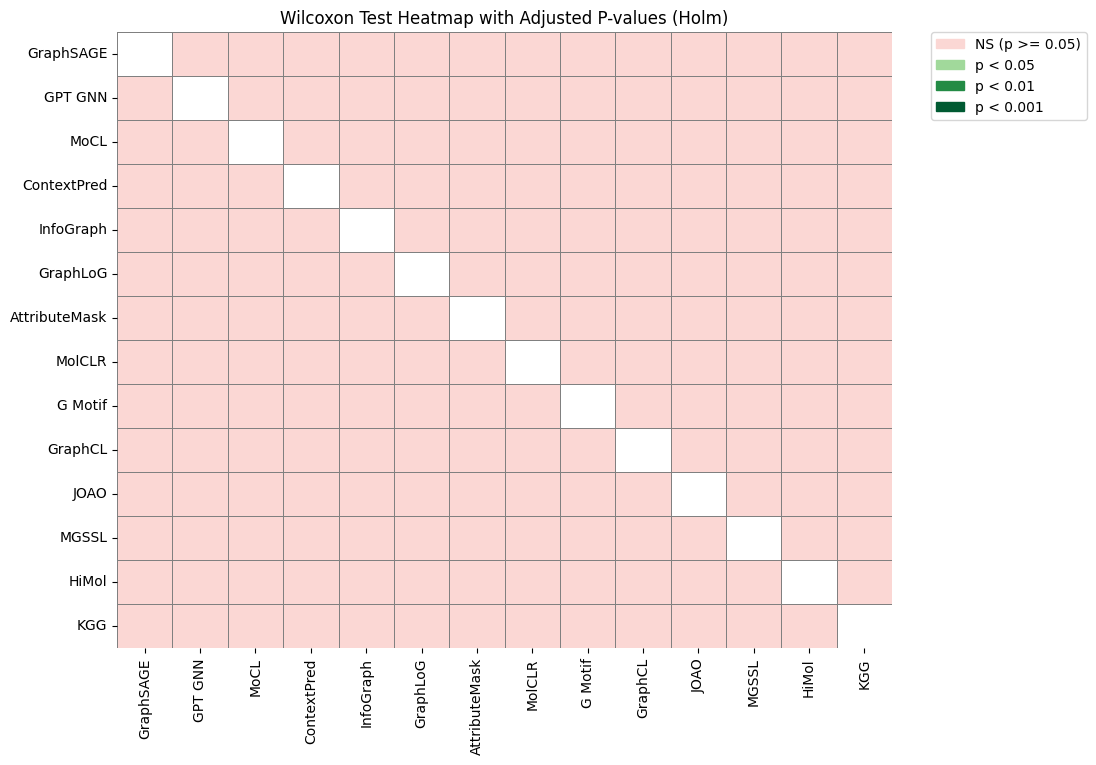

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, wilcoxon
from statsmodels.stats.multitest import multipletests

# Sample data for demonstration (replace this with your actual DataFrame)
# df_ttest = pd.DataFrame(...)  # Your data goes here

# Assuming df_ttest is your DataFrame
df = pd.DataFrame(df_ttest)

# Initialize matrices to store p-values for t-test and Wilcoxon test
t_p_values = np.zeros((df.shape[1], df.shape[1]))
w_p_values = np.zeros((df.shape[1], df.shape[1]))

# Perform t-test and Wilcoxon test between pairs of models and store results
for i in range(df.shape[1]):
    for j in range(df.shape[1]):
        if i != j:
            t_stat, t_p_val = ttest_ind(df.iloc[:, i], df.iloc[:, j])
            t_p_values[i, j] = t_p_val
            # Wilcoxon test requires paired samples
            try:
                w_stat, w_p_val = wilcoxon(df.iloc[:, i], df.iloc[:, j])
                w_p_values[i, j] = w_p_val
            except ValueError:
                w_p_values[i, j] = np.nan  # Handle cases where Wilcoxon cannot be applied
        else:
            t_p_values[i, j] = np.nan  # Do not compare the same model
            w_p_values[i, j] = np.nan

# Convert p-values to DataFrame for convenient heatmap plotting
t_p_values_df = pd.DataFrame(t_p_values, index=df.columns, columns=df.columns)
w_p_values_df = pd.DataFrame(w_p_values, index=df.columns, columns=df.columns)

# Adjust p-values using Holm method
def adjust_p_values(p_values_df):
    p_values_flat = p_values_df.values.flatten()
    adjusted_p_values = multipletests(p_values_flat, method='holm')[1]
    adjusted_p_values_df = pd.DataFrame(adjusted_p_values.reshape(p_values_df.shape), 
                                        index=p_values_df.index, columns=p_values_df.columns)
    return adjusted_p_values_df

t_adjusted_p_values_df = adjust_p_values(t_p_values_df)
w_adjusted_p_values_df = adjust_p_values(w_p_values_df)

# Custom colormap for specific p-value ranges
def custom_heatmap(p_values):
    color_map = p_values.copy()
    color_map[p_values < 0.001] = 3
    color_map[(p_values >= 0.001) & (p_values < 0.01)] = 2
    color_map[(p_values >= 0.01) & (p_values < 0.05)] = 1
    color_map[p_values >= 0.05] = 0
    return color_map

t_color_map = custom_heatmap(t_adjusted_p_values_df)
w_color_map = custom_heatmap(w_adjusted_p_values_df)

# Create a colormap with 4 colors
cmap = ['#fbd7d4', '#a1d99b', '#238b45', '#005a32']

# Plot heatmap for t-test
plt.figure(figsize=(10, 8))
sns.heatmap(t_color_map, annot=False, cmap=cmap, cbar=False, xticklabels=df.columns, yticklabels=df.columns, linewidths=.5, linecolor='gray')
plt.title("T-test Heatmap with Adjusted P-values (Holm)")

# Add a legend
legend_labels = ['NS (p >= 0.05)', 'p < 0.05', 'p < 0.01', 'p < 0.001']
colors = ['#fbd7d4', '#a1d99b', '#238b45', '#005a32']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(colors))]

plt.legend(handles, legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig('fig/ttest_heatmap_holm.png', dpi=600, transparent=False, bbox_inches='tight')
plt.show()

# Plot heatmap for Wilcoxon test
plt.figure(figsize=(10, 8))
sns.heatmap(w_color_map, annot=False, cmap=cmap, cbar=False, xticklabels=df.columns, yticklabels=df.columns, linewidths=.5, linecolor='gray')
plt.title("Wilcoxon Test Heatmap with Adjusted P-values (Holm)")

# Add a legend
plt.legend(handles, legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig('fig/wilcoxon_heatmap_holm.png', dpi=600, transparent=False, bbox_inches='tight')
plt.show()


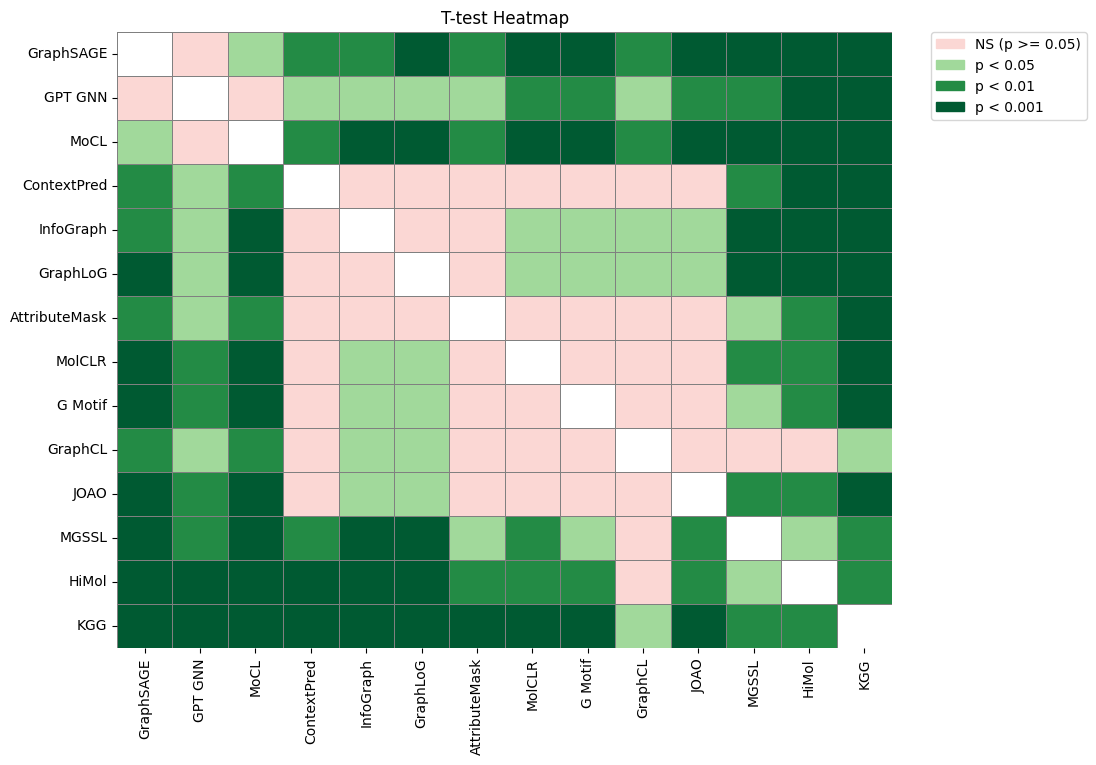

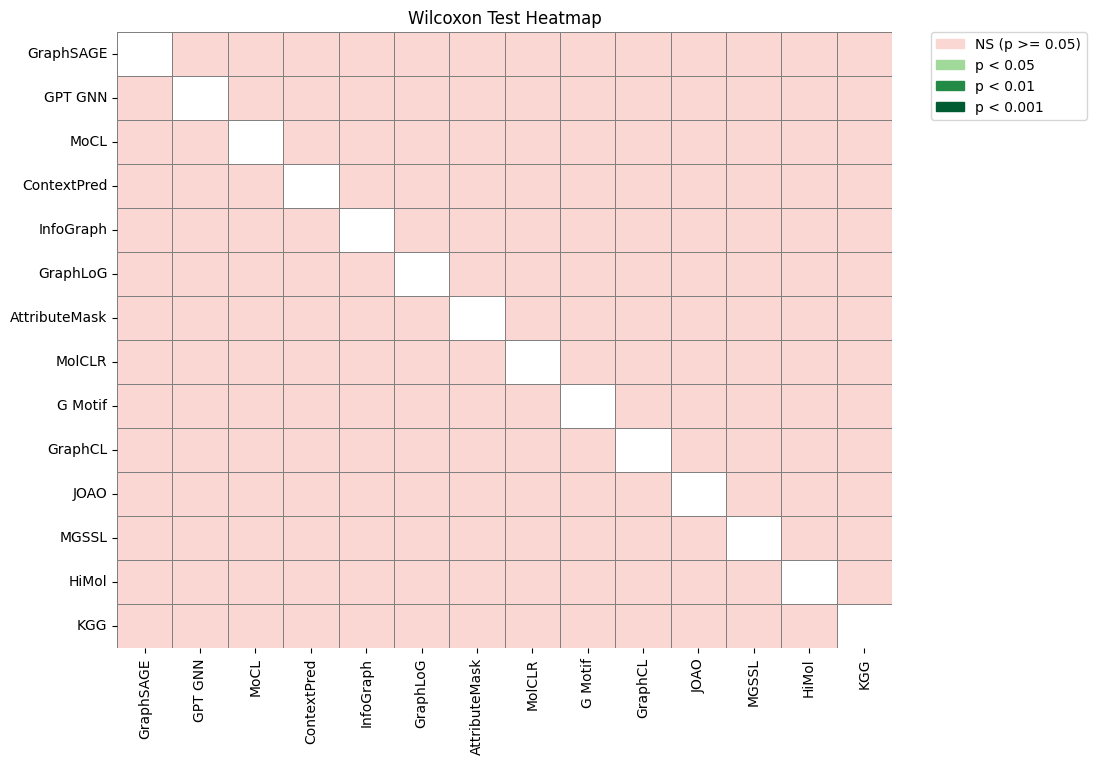

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, wilcoxon

# Sample data for demonstration (replace this with your actual DataFrame)
# df_ttest = pd.DataFrame(...)  # Your data goes here

# Assuming df_ttest is your DataFrame
df = pd.DataFrame(df_ttest)

# Initialize matrices to store p-values for t-test and Wilcoxon test
t_p_values = np.zeros((df.shape[1], df.shape[1]))
w_p_values = np.zeros((df.shape[1], df.shape[1]))

# Perform t-test and Wilcoxon test between pairs of models and store results
for i in range(df.shape[1]):
    for j in range(df.shape[1]):
        if i != j:
            t_stat, t_p_val = ttest_ind(df.iloc[:, i], df.iloc[:, j])
            t_p_values[i, j] = t_p_val
            # Wilcoxon test requires paired samples
            try:
                w_stat, w_p_val = wilcoxon(df.iloc[:, i], df.iloc[:, j])
                w_p_values[i, j] = w_p_val
            except ValueError:
                w_p_values[i, j] = np.nan  # Handle cases where Wilcoxon cannot be applied
        else:
            t_p_values[i, j] = np.nan  # Do not compare the same model
            w_p_values[i, j] = np.nan

# Convert p-values to DataFrame for convenient heatmap plotting
t_p_values_df = pd.DataFrame(t_p_values, index=df.columns, columns=df.columns)
w_p_values_df = pd.DataFrame(w_p_values, index=df.columns, columns=df.columns)

# Custom colormap for specific p-value ranges
def custom_heatmap(p_values):
    color_map = p_values.copy()
    color_map[p_values < 0.001] = 3
    color_map[(p_values >= 0.001) & (p_values < 0.01)] = 2
    color_map[(p_values >= 0.01) & (p_values < 0.05)] = 1
    color_map[p_values >= 0.05] = 0
    return color_map

t_color_map = custom_heatmap(t_p_values_df)
w_color_map = custom_heatmap(w_p_values_df)

# Create a colormap with 4 colors
cmap = ['#fbd7d4', '#a1d99b', '#238b45', '#005a32']

# Plot heatmap for t-test
plt.figure(figsize=(10, 8))
sns.heatmap(t_color_map, annot=False, cmap=cmap, cbar=False, xticklabels=df.columns, yticklabels=df.columns, linewidths=.5, linecolor='gray')
plt.title("T-test Heatmap")

# Add a legend
legend_labels = ['NS (p >= 0.05)', 'p < 0.05', 'p < 0.01', 'p < 0.001']
colors = ['#fbd7d4', '#a1d99b', '#238b45', '#005a32']
handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(colors))]

plt.legend(handles, legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig('fig/ttest_heatmap.png', dpi=600, transparent=False, bbox_inches='tight')
plt.show()

# Plot heatmap for Wilcoxon test
plt.figure(figsize=(10, 8))
sns.heatmap(w_color_map, annot=False, cmap=cmap, cbar=False, xticklabels=df.columns, yticklabels=df.columns, linewidths=.5, linecolor='gray')
plt.title("Wilcoxon Test Heatmap")

# Add a legend
plt.legend(handles, legend_labels, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.savefig('fig/wilcoxon_heatmap.png', dpi=600, transparent=False, bbox_inches='tight')
plt.show()


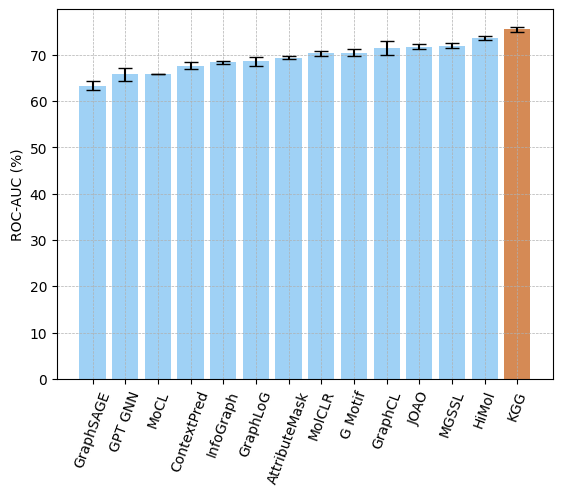

In [23]:
import matplotlib.pyplot as plt
df = pd.read_csv('data/classification_std.csv')
df = df.sort_values('Avg')

# Creating a color array
colors = ['#9FD1F5' if model != 'KGG' else '#D58A55' for model in df.Model]

# Plotting with custom color
plt.bar(df.Model, df['Avg'], color=colors, yerr=df['std'], capsize=5)

# Customizing the plot
plt.ylabel('ROC-AUC (%)')

# Adding a grid with custom size and weight
plt.grid(True, linewidth=0.5, linestyle='--')

# Rotating x-axis labels
plt.xticks(rotation=70)
plt.savefig('fig/avg_classification6.png', dpi=600, bbox_inches='tight')
# Displaying the plot
plt.show()

In [27]:
df_std = pd.read_excel('data/classification_std.xlsx')
df_std

,Model,BACE,BBBP,Tox21,ToxCast,SIDER,ClinTox,Avg
0,GraphSAGE,72.7 ± 3.3,67.7 ± 2.8,69.9 ± 1.1,59.1 ± 0.3,58.3 ± 0.2,52.1 ± 5.5,63.3
1,GPT GNN,72.5 ± 0.8,69.3 ± 1.3,73.1 ± 0.7,59.8 ± 0.4,59.6 ± 3.5,60.4 ± 3.3,65.8
2,AttributeMask,80.1 ± 0.4,65.9 ± 1.3,74.6 ± 0.3,63.7 ± 0.4,58.2 ± 0.6,74.0 ± 2.3,69.4
3,ContextPred,77.7 ± 1.3,68.6 ± 0.9,72.7 ± 0.6,62.1 ± 0.4,58.8 ± 1.1,71.1 ± 3.6,67.7
4,InfoGraph,76.6 ± 1.8,68.8 ± 0.7,74.7 ± 0.4,60.8 ± 0.8,56.7 ± 0.9,72.9 ± 4.7,68.4
5,MoCL,75.1 ± 0.1,66.8 ± 0.1,70.9 ± 0.2,60.7 ± 0.1,61.2 ± 0.1,60.8 ± 0.1,65.9
6,GraphLoG,79.0 ± 0.7,65.7 ± 1.4,73.4 ± 0.3,63.4 ± 0.4,57.3 ± 2.3,72.5 ± 1.8,68.6
7,GraphCL,72.8 ± 5.4,69.5 ± 2.6,75.0 ± 0.3,63.2 ± 0.4,61.4 ± 1.3,78.9 ± 4.2,71.5
8,JOAO,72.2 ± 2.0,70.7 ± 0.6,75.5 ± 0.7,61.6 ± 0.6,61.1 ± 0.9,79.6 ± 3.7,71.8
9,MolCLR,76.5 ± 0.5,69.3 ± 0.5,74.2 ± 0.8,55.0 ± 1.3,56.4 ± 0.3,90.4 ± 1.7,70.3


In [28]:
# Splitting the 'ROC-AUC' column into 'value' and 'std' columns
for column in df_std.drop(["Model", "Avg"], axis=1).columns:
    df_std[[column, column + 'std']] = df_std[column].str.split('±', expand=True)

In [29]:
df_std

,Model,BACE,BBBP,Tox21,ToxCast,SIDER,ClinTox,Avg,BACEstd,BBBPstd,Tox21std,ToxCaststd,SIDERstd,ClinToxstd
0,GraphSAGE,72.7,67.7,69.9,59.1,58.3,52.1,63.3,3.3,2.8,1.1,0.3,0.2,5.5
1,GPT GNN,72.5,69.3,73.1,59.8,59.6,60.4,65.8,0.8,1.3,0.7,0.4,3.5,3.3
2,AttributeMask,80.1,65.9,74.6,63.7,58.2,74.0,69.4,0.4,1.3,0.3,0.4,0.6,2.3
3,ContextPred,77.7,68.6,72.7,62.1,58.8,71.1,67.7,1.3,0.9,0.6,0.4,1.1,3.6
4,InfoGraph,76.6,68.8,74.7,60.8,56.7,72.9,68.4,1.8,0.7,0.4,0.8,0.9,4.7
5,MoCL,75.1,66.8,70.9,60.7,61.2,60.8,65.9,0.1,0.1,0.2,0.1,0.1,0.1
6,GraphLoG,79.0,65.7,73.4,63.4,57.3,72.5,68.6,0.7,1.4,0.3,0.4,2.3,1.8
7,GraphCL,72.8,69.5,75.0,63.2,61.4,78.9,71.5,5.4,2.6,0.3,0.4,1.3,4.2
8,JOAO,72.2,70.7,75.5,61.6,61.1,79.6,71.8,2.0,0.6,0.7,0.6,0.9,3.7
9,MolCLR,76.5,69.3,74.2,55.0,56.4,90.4,70.3,0.5,0.5,0.8,1.3,0.3,1.7


In [30]:
# Defining a function to remove the non-breaking space and convert to float
def convert_value(value):
    if type(value) is not float:
        return float(value.replace('\u2009', ''))
    else:
        return value
df_rm_model = df_std.drop("Model", axis=1)
# Applying the function to all values in the DataFrame
df_float = df_rm_model.applymap(convert_value)

df_std_new = pd.concat([df_std['Model'], df_float], axis=1)
df_std_new.to_csv('data/classification_std.csv', index=False)

/tmp/ipykernel_55927/4134338265.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_float = df_rm_model.applymap(convert_value)


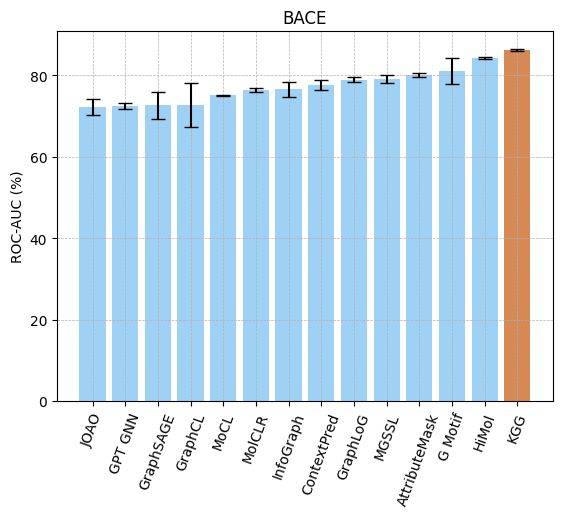

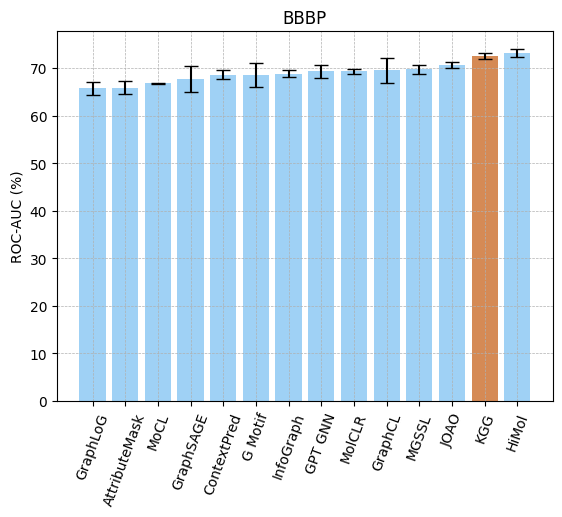

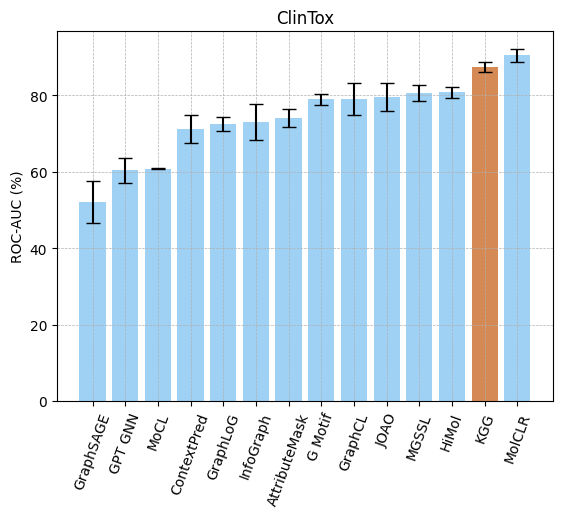

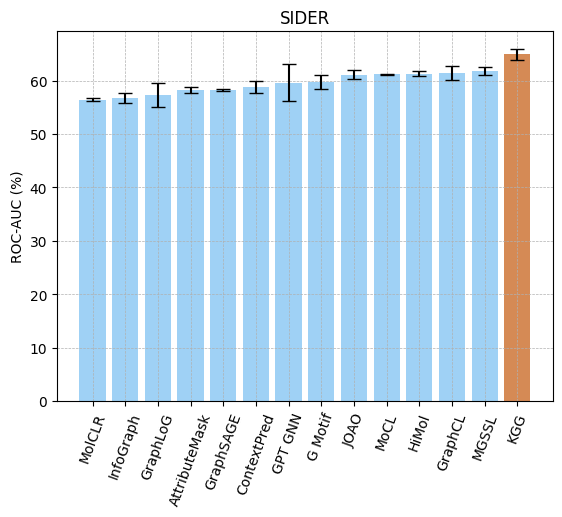

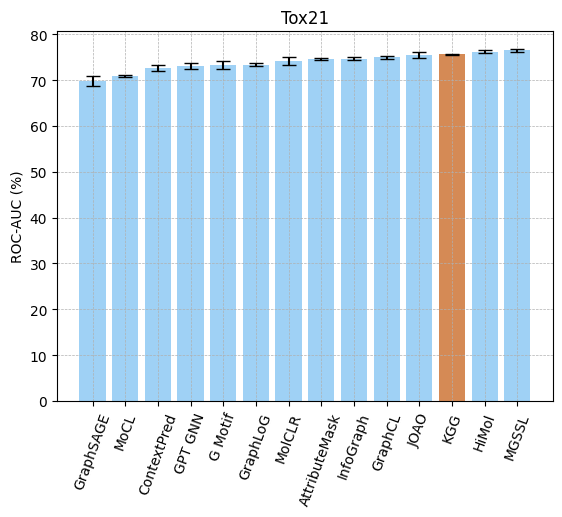

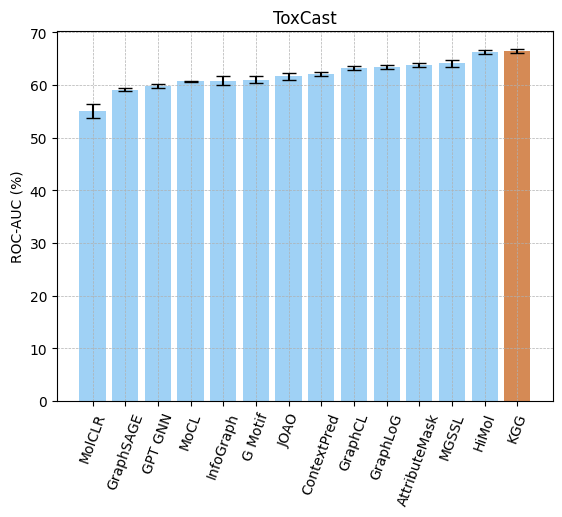

In [31]:
import matplotlib.pyplot as plt
for dataset in ["BACE", "BBBP", "ClinTox", "SIDER", "Tox21", "ToxCast"]:
    df_std_new = df_std_new.sort_values(dataset)

    # Creating a color array
    colors = ['#9FD1F5' if model != 'KGG' else '#D58A55' for model in df_std_new.Model]

    # Assuming 'df_std_T' is your DataFrame and it has an 'avg' column for average values
    # and a 'std' column for standard deviation values
    # Plotting
    plt.bar(df_std_new.Model, df_std_new[dataset], yerr=df_std_new[f'{dataset}std'], capsize=5, color=colors)

    # Customizing the plot
    plt.title(f'{dataset}')
    plt.ylabel('ROC-AUC (%)')

    # Adding a grid with custom size and weight
    plt.grid(True, linewidth=0.5, linestyle='--')

    # Rotating x-axis labels
    plt.xticks(rotation=70)
    plt.savefig(f'fig/std_{dataset}.png', dpi=600, bbox_inches='tight')
    # Displaying the plot
    plt.show()